In [1]:
import pandas as pd
from rdkit import Chem, rdBase
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdRGroupDecomposition as rdRGD

from rgroupinterm.rgroupenumeration import EnumRGroups

rdBase.DisableLog('rdApp.*')

In [2]:
smiles = [
    'CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc(O)cc1)N2',
    '[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccccc1'
]
mols = [Chem.MolFromSmiles(x) for x in smiles]

generator = EnumRGroups()

df_interm, core_new = generator.generate_intermediates(mols)
intermediates = df_interm['Intermediate'].tolist()

print(len(intermediates))

6


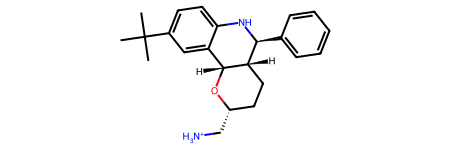

In [4]:
intermediates[5]

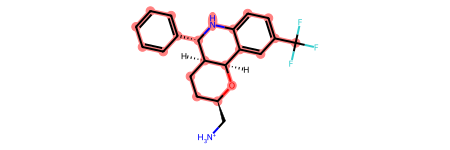

In [5]:
mols[1]

In [3]:
generator.bondorder

defaultdict(dict,
            {0: {3: [0, 2, 3, 4], 2: [11, 13], 1: [19, 21, 22]},
             1: {2: [1, 3, 7], 3: [10, 12, 13, 14], 1: [22, 24]}})

In [58]:
indices = []
bond_info = []
for bond in mols[1].GetAtomWithIdx(2).GetBonds():
    indices.append(bond.GetIdx())
    bond_info.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()))
print("Matched bond indices:", indices)
print(bond_info)

Matched bond indices: [1, 2, 25]
[(1, 2, rdkit.Chem.rdchem.BondType.SINGLE), (2, 3, rdkit.Chem.rdchem.BondType.SINGLE), (7, 2, rdkit.Chem.rdchem.BondType.SINGLE)]


In [65]:
smiles = 'CC(C)(C)C1=CC=C2N[C@@H](C3=CC=C(O)C=C3)[C@@H]3CCC(C[NH3+])O[C@@H]3C2=C1'
connected_mol = Chem.MolFromSmiles(smiles)
rw_mol = Chem.RWMol(mol)
bond_info = []
for bond in rw_mol.GetAtomWithIdx(20).GetBonds():
    bond_info.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()))
    rw_mol.RemoveBond(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
print(bond_info)

for i in [1, 0, 2]:
    rw_mol.AddBond(*bond_info[i])

rw_mol.GetAtomWithIdx(20).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)

mol_new = rw_mol.GetMol()
# mol = Chem.Mol(mol_new)
# # Chem.rdDepictor.GenerateDepictionMatching2DStructure(connected_mol, core)
# def mol_with_atom_index(mol):
#     for atom in mol.GetAtoms():
#         atom.SetAtomMapNum(atom.GetIdx())
#     return mol
# mol_with_atom_index(mol)

[(19, 20, rdkit.Chem.rdchem.BondType.SINGLE), (20, 21, rdkit.Chem.rdchem.BondType.SINGLE), (20, 23, rdkit.Chem.rdchem.BondType.SINGLE)]


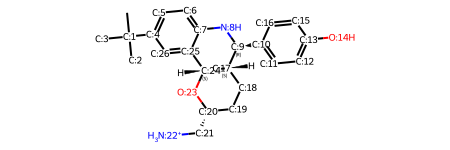

In [66]:
mol_new

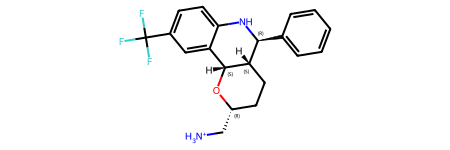

In [67]:
mols[1]

CHI_TETRAHEDRAL_CW


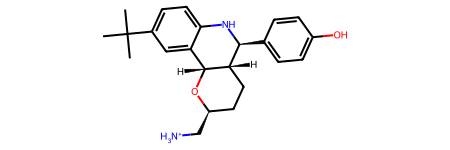

In [30]:
connected_mol.GetAtomWithIdx(20).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
print(connected_mol.GetAtomWithIdx(20).GetChiralTag())
connected_mol

In [36]:
smiles = 'CC(C)(C)C1=CC=C2N[C@@H](C3=CC=C(O)C=C3)[C@@H]3CCC(C[NH3+])O[C@@H]3C2=C1'
combined_mol = Chem.MolFromSmiles(smiles)
final_mol = Chem.RemoveHs(combined_mol)
Chem.SanitizeMol(final_mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

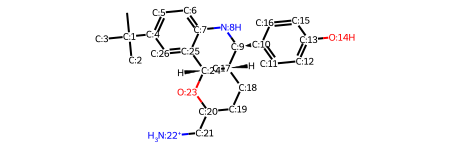

In [37]:
mol = Chem.Mol(final_mol)
# Chem.rdDepictor.GenerateDepictionMatching2DStructure(connected_mol, core)
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
mol_with_atom_index(mol)

CHI_TETRAHEDRAL_CW


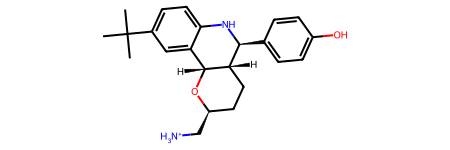

In [38]:
final_mol.GetAtomWithIdx(20).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
print(final_mol.GetAtomWithIdx(20).GetChiralTag())
final_mol

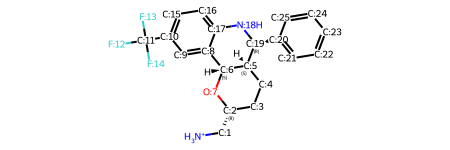

In [55]:
mols[1]
mol = Chem.Mol(mols[1])
# Chem.rdDepictor.GenerateDepictionMatching2DStructure(connected_mol, core)
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
mol_with_atom_index(mol)

In [33]:
print(mols[1].GetAtomWithIdx(2).GetChiralTag())

CHI_TETRAHEDRAL_CW


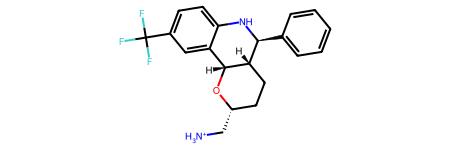

In [34]:
mols[1]

In [11]:
res = rdFMCS.FindMCS(mols,
                        matchValences=True,
                        ringMatchesRingOnly=True,
                        completeRingsOnly=True,
                        timeout=2)
core = Chem.MolFromSmarts(res.smartsString)

Chem.rdDepictor.Compute2DCoords(core)
for mol in mols:
    Chem.rdDepictor.GenerateDepictionMatching2DStructure(mol,core)

In [14]:
res, _ = rdRGD.RGroupDecompose([core],
                                mols,
                                asSmiles=False,
                                asRows=False)
df_rgroup = pd.DataFrame(res)

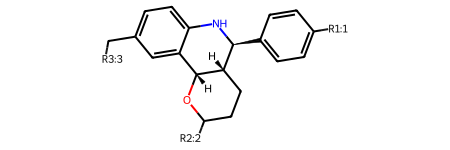

In [15]:
df_rgroup['Core'][0]

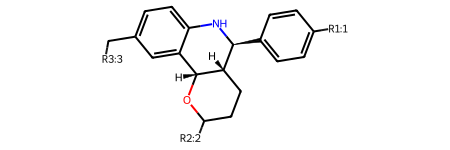

In [16]:
df_rgroup['Core'][1]

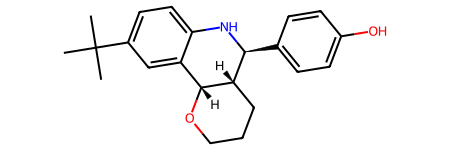

In [4]:
mols[0]

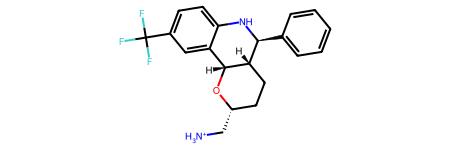

In [5]:
mols[1]

In [6]:
len(intermediates)

7

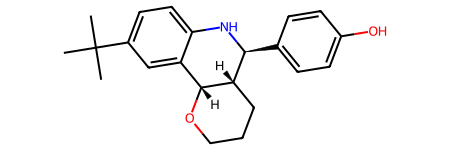

In [7]:
mols[0]

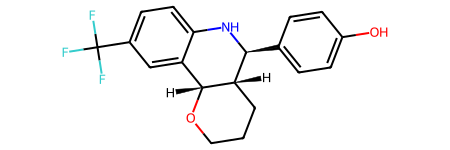

In [8]:
intermediates[0]

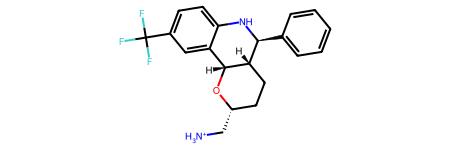

In [9]:
mols[1]

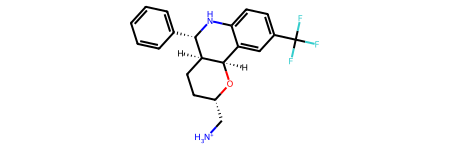

In [10]:
intermediates[-1]

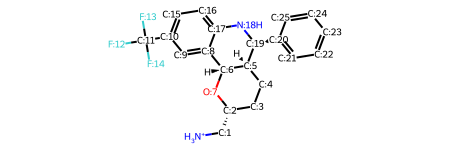

In [11]:
mol = mols[1]
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
mol_with_atom_index(mol)

In [12]:
mol.GetAtomWithIdx(2).GetChiralTag()

rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW

In [ ]:
mol.GetAtomWithIdx(2).GetChiralTag()

rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW

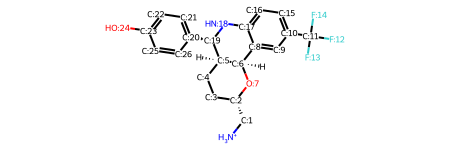

In [ ]:
intermediates[2]

In [40]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
IPythonConsole.drawOptions.addStereoAnnotation = True
IPythonConsole.ipython_useSVG=True 

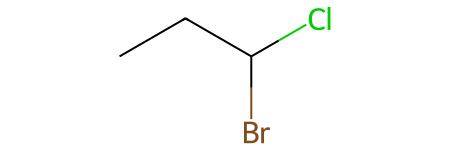

In [41]:
smiles = "C(Cl)(Br)CC"
mol = Chem.MolFromSmiles(smiles)
display(mol)

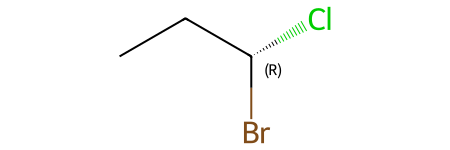

In [42]:
smiles_ref = "Br[C@@H](Cl)CC"
mol_ref = Chem.MolFromSmiles(smiles_ref)
display(mol_ref)

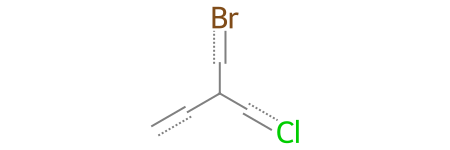

In [43]:
smarts = "[C][C@@H]([Br])[Cl]"
pattern = Chem.MolFromSmarts(smarts)
display(pattern)

Matched indices: (3, 0, 2, 1)


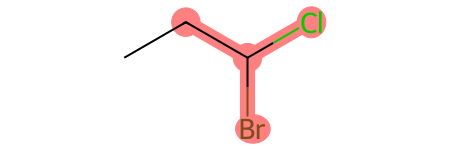

In [44]:
match = mol.GetSubstructMatch(pattern)
print("Matched indices:", match)
display(mol)

In [45]:
indices_matched = []
for bond in pattern.GetBonds():
    i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    bond = mol.GetBondBetweenAtoms(match[i], match[j])
    indices_matched.append(bond.GetIdx())
print("Matched bond indices:", indices_matched)

Matched bond indices: [2, 1, 0]


In [46]:
indices_all = list(range(mol.GetNumBonds()))
indices_rest = [i for i in indices_all if i not in indices_matched]
indices_new = indices_matched + indices_rest
print("Rest of bond indices:", indices_rest)
print("New bond index order:", indices_new)

Rest of bond indices: [3]
New bond index order: [2, 1, 0, 3]


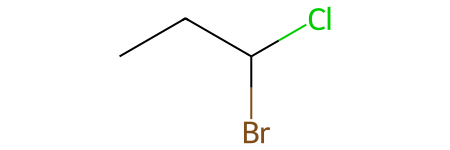

In [50]:
rw_mol = Chem.RWMol(mol)

bond_info = []
for bond in list(rw_mol.GetBonds()):
    bond_info.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()))
    rw_mol.RemoveBond(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

for i in indices_new:
    rw_mol.AddBond(*bond_info[i])
display(rw_mol)

CHI_UNSPECIFIED
CHI_TETRAHEDRAL_CW
CHI_UNSPECIFIED
CHI_UNSPECIFIED


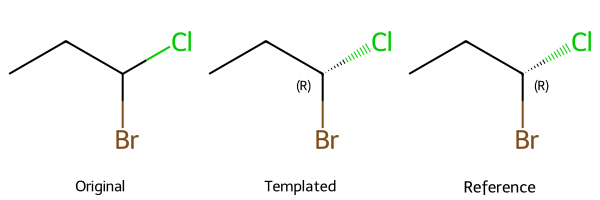

In [53]:
for i, atom in enumerate(pattern.GetAtoms()):
    chiral_tag = atom.GetChiralTag()
    print(chiral_tag)
    rw_mol.GetAtomWithIdx(match[i]).SetChiralTag(chiral_tag)
    
mol_new = rw_mol.GetMol()
Chem.SanitizeMol(mol_new)
Chem.AssignCIPLabels(mol_new)

Chem.Draw.MolsToGridImage([mol, mol_new, mol_ref], legends=["Original", "Templated", "Reference"], molsPerRow=3, useSVG=True)